In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

sns.set_style("whitegrid")


In this notebook, we try several different models on the training set, using cross-validation. The models are all k-neighbors regression, albeit with different features and one of them having a sort of weighted distance metric applying infinite weight to borough distinction.

In [3]:
#read in the training dataset
rd_train = pd.read_csv("/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/train_data.csv")

In [4]:
#import the modules necessary for cross-validation and regression via pipelines
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [5]:
n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle = True, random_state= 5501)

We shall assess our models' performance both universally and with respect to each individual borough.

In [6]:
boroughs = np.sort(rd_train.borough.unique())

## K Neighbors Regression (Geospatial)

In [7]:
#form a 'multiindex' dataframe for k and borough
num_k = 50

many_boroughs = np.array([])
many_ks = []
for i in range(num_k): 
    many_boroughs = np.concatenate((boroughs, many_boroughs))
    many_ks = many_ks + len(boroughs)*[i]


In [8]:
#use cross validation to find best universal k and avg. CV rmse, as well as borough-specific k's and rmse's
rmse = np.zeros((num_k, n_splits))

rmse_df = pd.DataFrame({"borough": many_boroughs, "k": many_ks})
for k in range(num_k):
    knn = KNeighborsRegressor(k+1)
    i = 0
    for train_index, test_index in kfold.split(rd_train, rd_train.borough):
         rd_t_train= rd_train.iloc[train_index]
         rd_t_test = rd_train.iloc[test_index]

         knn.fit(rd_t_train[['latitude', 'longitude']], rd_t_train.rating)
         preds = knn.predict(rd_t_test[['latitude', 'longitude']])
         rmse[k, i] = root_mean_squared_error(rd_t_test.rating, preds)
         
         for bor in rd_t_test.borough.unique():
              rd_t_bor = rd_t_test[rd_t_test.borough == bor]
              bor_preds = knn.predict(rd_t_bor[['latitude', 'longitude']])
              rmse_df.loc[(rmse_df.borough == bor) &(rmse_df.k == k), i] = root_mean_squared_error(rd_t_test[rd_t_test.borough == bor].rating,
                                                                               bor_preds)
         
         i += 1

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least

In [9]:
#this is code for finding the best k for each borough

#add column with average of the available rmse's
rmse_df['Avg. RMSE'] = rmse_df.iloc[:, -5:].sum(axis = 1)/(n_splits - rmse_df.isna().sum(axis = 1))

#find the best k
def find_k(data, borough):
    df = data[data.borough == borough]
    return np.argmin(df['Avg. RMSE']) + 1

best_ks = [find_k(rmse_df, bor) for bor in boroughs]

min_rmses = [rmse_df.loc[(rmse_df.k == best_ks[i] -1) & 
                         (rmse_df.borough == boroughs[i]), 'Avg. RMSE'].reset_index(drop=True)[0] for i in range(len(boroughs))]


#give the desired dataframe

gen_k_neigh = pd.DataFrame({'Borough': boroughs, "Best k": best_ks, "CV Avg. RMSE": min_rmses})

gen_k_neigh

,Borough,Best k,CV Avg. RMSE
0,Allegheny West,48,0.345464
1,Bella Vista,23,0.190454
2,Bensalem,15,0.476567
3,Center City,18,0.327539
4,Center City East,47,0.339561
5,Chestnut Hill,38,0.301278
6,East Germantown,10,0.497392
7,East Kensington,3,0.189985
8,East Passyunk Crossing,7,0.304203
9,Elmwood Park,31,0.375245


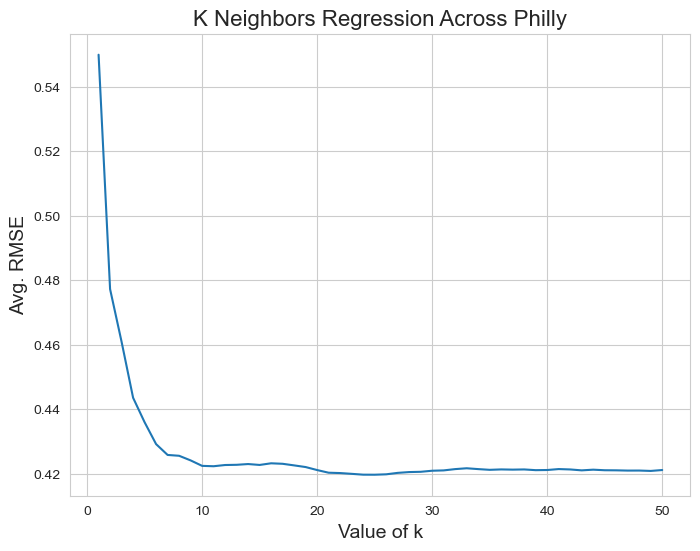

In [10]:
plt.figure(figsize=(8,6))

plt.plot(np.arange(1, num_k+1), np.mean(rmse, axis = 1))
plt.xlabel('Value of k', fontsize = 14)
plt.ylabel('Avg. RMSE', fontsize= 14)
plt.title("K Neighbors Regression Across Philly", fontsize = 16)

plt.show()

## Borough-Specific K Neighbors Regression

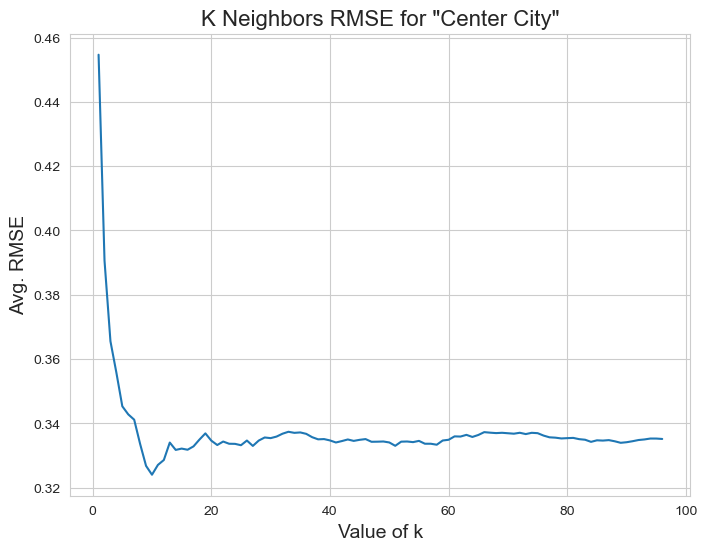

In [11]:
reg_kfold = KFold(n_splits, shuffle = True, random_state= 5190)

center_city = rd_train[rd_train.borough == 'Center City']
num_k = np.round(0.75*len(center_city)).astype(int)
rmse = np.zeros((num_k, n_splits))
for k in range(num_k):
    knn = KNeighborsRegressor(k+1)
    i = 0
    for train_index, test_index in reg_kfold.split(center_city):
         rd_t_train= center_city.iloc[train_index]
         rd_t_test = center_city.iloc[test_index]

         knn.fit(rd_t_train[['latitude', 'longitude']], rd_t_train.rating)
         preds = knn.predict(rd_t_test[['latitude', 'longitude']])
         rmse[k, i] = root_mean_squared_error(rd_t_test.rating, preds)
         i += 1
         
plt.figure(figsize=(8,6))

plt.plot(np.arange(1, num_k+1), np.mean(rmse, axis = 1))
plt.xlabel('Value of k', fontsize = 14)
plt.ylabel('Avg. RMSE', fontsize= 14)
plt.title('K Neighbors RMSE for "Center City"', fontsize = 16)
plt.show()


In [12]:
reg_kfold = KFold(n_splits, shuffle = True, random_state= 5501)

bor_info = []
for bor in boroughs:
    rd_bor = rd_train[rd_train.borough == bor]
    if len(rd_bor) > n_splits:
    #each borough places a possibly different limit on how many neighbors we can take
        num_k = np.round(0.75*len(rd_bor)).astype(int)
        rmse = np.zeros((num_k, n_splits))
        for k in range(num_k):
            knn = KNeighborsRegressor(k+1)
            i = 0
            for train_index, test_index in reg_kfold.split(rd_bor):
                rd_t_train= rd_bor.iloc[train_index]
                rd_t_test = rd_bor.iloc[test_index]

                knn.fit(rd_t_train[['latitude', 'longitude']], rd_t_train.rating)
                preds = knn.predict(rd_t_test[['latitude', 'longitude']])
                rmse[k, i] = root_mean_squared_error(rd_t_test.rating, preds)
                i += 1
         
        rmse = np.mean(rmse, axis = 1)
        best_k = np.argmin(rmse)
        min_rmse = rmse[best_k]
        bor_info.append({'Borough': bor, 'Best k': best_k +1, 'Min. RMSE': min_rmse})




In [13]:
k_neigh_df = pd.DataFrame(bor_info)
k_neigh_df["Number of Restaurants"] = [len(rd_train[rd_train.borough == bor]) for bor in np.sort(rd_train.borough.unique())
                                       if (len(rd_train[rd_train.borough == bor]) > n_splits)]
k_neigh_df

,Borough,Best k,Min. RMSE,Number of Restaurants
0,Allegheny West,8,0.360631,22
1,Bella Vista,6,0.208949,33
2,Bensalem,4,0.705114,6
3,Center City,11,0.322179,128
4,Center City East,10,0.336999,212
5,Chestnut Hill,1,0.276455,22
6,East Germantown,20,0.534539,26
7,East Kensington,8,0.200562,10
8,East Passyunk Crossing,4,0.268043,26
9,Elmwood Park,26,0.372289,35


The estimates seem mostly to have gotten a bit worse, with the exception of "Essington" for example. However, the value of k was frequently reduced here, sometimes noticeably. This seems to show that most boroughs, with the exception of that one, have a sizable proportion of restaurants on their periphery. There is apparently some sort of tradeoff between proximity and "borough culture."

At this point, it seems a reasonable goal may be to attain avg. CV RMSE of about 0.3 for ratings within the training set, with much more reasonable numbers of neighbors being taken.

## K Neighbors Regression with More Features, Not Borough-Specific

We shall remove now the barriers placed between boroughs and apply additional features beyond latitude and longitude.

In [14]:
with open("/Users/dominiquekemp/Documents/GitHub/'Will It Restaurant?'/features.csv", "r") as file:
    features = [line.strip() for line in file]

features

['type',
 'category',
 'site',
 'phone',
 'booking_appointment_link',
 'range',
 'latitude',
 'longitude',
 'postal_code',
 'borough',
 'working_hours_old_format',
 'other_hours',
 'range',
 'photos_count',
 'reviews_per_score_1',
 'reviews_per_score_2',
 'reviews']

In [15]:
#the features we shall use here
reduced_cols = ['latitude', 'longitude', 'borough', 'photos_count', 'reviews', 'rating']


In [16]:
#make cuisine comparison a feature
df = pd.concat([rd_train[reduced_cols], pd.get_dummies(rd_train.type)], axis= 1)

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
many_boroughs = np.array([])
many_ks = []
for i in range(num_k): 
    many_boroughs = np.concatenate((boroughs, many_boroughs))
    many_ks = many_ks + len(boroughs)*[i]


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least

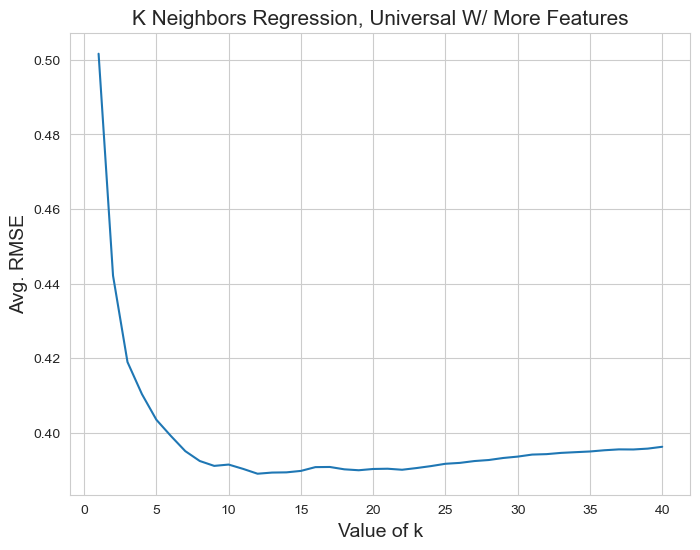

In [19]:
#try k-neighbors with a few more features including cuisine type



num_k = 40
rmse = np.zeros((num_k, n_splits))

rmse_df = pd.DataFrame({"k": many_ks, "borough": many_boroughs})
cols = df.columns
cols = cols.drop(['rating', 'borough'])
for k in range(num_k):
    knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])
    i = 0
    for train_index, test_index in kfold.split(df, df.borough):
         df_train= df.iloc[train_index]
         df_test = df.iloc[test_index]

         knn_pipe.fit(df_train[cols], df_train.rating)
         preds = knn_pipe.predict(df_test[cols])
         rmse[k, i] = root_mean_squared_error(df_test.rating, preds)
         
         for bor in df_test.borough.unique():
              df_bor = df_test[df_test.borough == bor]
              bor_preds = knn_pipe.predict(df_bor[cols])
              rmse_df.loc[(rmse_df.k == k) & (rmse_df.borough == bor), i] = root_mean_squared_error(df_test[df_test.borough == bor].rating,
                                                                               bor_preds)
         
         i += 1

plt.figure(figsize=(8,6))

plt.plot(np.arange(1, num_k+1), np.mean(rmse, axis = 1))
plt.xlabel('Value of k', fontsize = 14)
plt.ylabel('Avg. RMSE', fontsize= 14)
plt.title("K Neighbors Regression, Universal W/ More Features", fontsize = 15)

plt.show()

In [20]:
rmse_avgs = np.mean(rmse, axis = 1)
best_k = np.argmin(rmse_avgs)
print(f"The minimum CV avg. RMSE is {rmse_avgs[best_k]: .3f}, occurring at k = {best_k +1}.")

The minimum CV avg. RMSE is  0.389, occurring at k = 12.


In [21]:
#locate best k for each borough
rmse_df['Avg. RMSE'] = rmse_df.iloc[:, -5:].sum(axis = 1)/(n_splits - rmse_df.isna().sum(axis = 1))

best_ks = [find_k(rmse_df, bor) for bor in boroughs]

min_rmses = [rmse_df.loc[(rmse_df.k == best_ks[i] -1) & 
                         (rmse_df.borough == boroughs[i]), 'Avg. RMSE'].reset_index(drop=True)[0] for i in range(len(boroughs))]

gen_k_neigh_more = pd.DataFrame({'Borough': boroughs, "Best k": best_ks, "CV Avg. RMSE": min_rmses})

#view the improvements/loss
pd.concat((gen_k_neigh_more, gen_k_neigh, k_neigh_df.iloc[:,-5:-1]), axis = 1)

,Borough,Best k,CV Avg. RMSE,Borough,Best k,CV Avg. RMSE,Borough,Best k,Min. RMSE
0,Allegheny West,5,0.272305,Allegheny West,48,0.345464,Allegheny West,8.0,0.360631
1,Bella Vista,5,0.265526,Bella Vista,23,0.190454,Bella Vista,6.0,0.208949
2,Bensalem,4,0.467987,Bensalem,15,0.476567,Bensalem,4.0,0.705114
3,Center City,5,0.351571,Center City,18,0.327539,Center City,11.0,0.322179
4,Center City East,5,0.347562,Center City East,47,0.339561,Center City East,10.0,0.336999
5,Chestnut Hill,2,0.271802,Chestnut Hill,38,0.301278,Chestnut Hill,1.0,0.276455
6,East Germantown,5,0.409866,East Germantown,10,0.497392,East Germantown,20.0,0.534539
7,East Kensington,5,0.228961,East Kensington,3,0.189985,East Kensington,8.0,0.200562
8,East Passyunk Crossing,5,0.401182,East Passyunk Crossing,7,0.304203,East Passyunk Crossing,4.0,0.268043
9,Elmwood Park,2,0.387735,Elmwood Park,31,0.375245,Elmwood Park,26.0,0.372289


In the above dataframe, we aimed to juxtapose all model results attained thus far. However, it is clearly misaligned due to some boroughs having too few restaurants to be amenable to borough-specific regression. We fix this now.

In [22]:
missing_bor = [bor for bor in boroughs if not np.isin(bor, k_neigh_df.Borough)]
rest_dict = {"Borough": missing_bor} | {k_neigh_df.columns[i]: len(missing_bor)*[0] for i in range(1,4)}
rest = pd.DataFrame(rest_dict)
rest.loc[:, "Min. RMSE"] =1
rest.loc[:, "Number of Restaurants"] = [len(rd_train[rd_train.borough == bor]) for bor in missing_bor]
k_neigh_df1 = pd.concat([k_neigh_df, rest], ignore_index=True)
k_neigh_df1.sort_values(by = "Borough", inplace=True)
k_neigh_df1.reset_index(drop = True, inplace = True)


For those boroughs that are missing from the final set of columns, we assign dummy values of k and RMSE that clearly prevent these boroughs from being considered for this model. 

In [23]:
k_neigh_df1

,Borough,Best k,Min. RMSE,Number of Restaurants
0,Allegheny West,8,0.360631,22
1,Bella Vista,6,0.208949,33
2,Bensalem,4,0.705114,6
3,Center City,11,0.322179,128
4,Center City East,10,0.336999,212
5,Chestnut Hill,1,0.276455,22
6,East Germantown,20,0.534539,26
7,East Kensington,8,0.200562,10
8,East Passyunk Crossing,4,0.268043,26
9,Elmwood Park,26,0.372289,35


Out of curiosity, we search for the best performing boroughs.

In [24]:
#label the dataframe presenting for all of the models
all_models = pd.concat((gen_k_neigh_more, gen_k_neigh.drop("Borough", axis = 1), k_neigh_df1.iloc[:,-3:]), axis = 1)

#find the boroughs with corresponding model that yields RMSE at most 0.225
best_models = pd.DataFrame(index = boroughs)
i=0
for bor in boroughs:
    errs = [np.append(all_models[all_models.Borough == bor].values[0, [j-1, j]], j) for j in [2,4,6] if 
            all_models[all_models.Borough == bor].values[0, j] < 0.225]
    if errs:
        errs = np.array(errs)
        best_loc = np.argmin(errs[:, 0])
        models = {2: "General k w/ More Features", 4: "General k", 6: "Borough-based k"}
        best_models.loc[bor, ["Best k", 'Min. RMSE', 'Best Model', "Restaurants Tally"]] = [errs[best_loc, 0], errs[best_loc, 1], 
                                                                                             models[errs[best_loc, 2]], k_neigh_df1['Number of Restaurants'][i]]
    i+=1

        
best_models

,Best k,Min. RMSE,Best Model,Restaurants Tally
Allegheny West,NaN,NaN,NaN,NaN
Bella Vista,6.0,0.208949,Borough-based k,33.0
Bensalem,NaN,NaN,NaN,NaN
Center City,NaN,NaN,NaN,NaN
Center City East,NaN,NaN,NaN,NaN
Chestnut Hill,NaN,NaN,NaN,NaN
East Germantown,NaN,NaN,NaN,NaN
East Kensington,3.0,0.189985,General k,10.0
East Passyunk Crossing,NaN,NaN,NaN,NaN
Elmwood Park,NaN,NaN,NaN,NaN


Let us review our findings thus far to determine next steps.

In [25]:
all_models.set_index('Borough', inplace = True)



## Some More Modeling

We see what impact occurs from adding or removing some features.

In [26]:
cols = cols.to_list()
cols.append('site')

In [27]:
cols

['latitude',
 'longitude',
 'photos_count',
 'reviews',
 'Afghan restaurant',
 'African restaurant',
 'American restaurant',
 'Amusement center',
 'Asian fusion restaurant',
 'Asian restaurant',
 'Association / Organization',
 'Açaí shop',
 'Bagel shop',
 'Bakery',
 'Bangladeshi restaurant',
 'Bar',
 'Bar & grill',
 'Barbecue restaurant',
 'Bed & breakfast',
 'Beer garden',
 'Beer hall',
 'Beer store',
 'Bistro',
 'Brazilian restaurant',
 'Breakfast restaurant',
 'Brewery',
 'Brewpub',
 'Brunch restaurant',
 'Bubble tea store',
 'Buffet restaurant',
 'Burrito restaurant',
 'Cafe',
 'Cafeteria',
 'Cajun restaurant',
 'Cambodian restaurant',
 'Caribbean restaurant',
 'Caterer',
 'Catering equipment rental service',
 'Cheesesteak restaurant',
 'Chicken restaurant',
 'Chicken wings restaurant',
 'Chinese restaurant',
 'Chinese takeaway',
 'Club',
 'Cocktail bar',
 'Coffee shop',
 'Colombian restaurant',
 'Convenience store',
 'Cooking class',
 'Crab house',
 'Creperie',
 'Cuban restaurant'

In [28]:
bor_info = []
df = pd.concat((df, rd_train['site']), axis =1)
for bor in boroughs:
    df_bor = df[df.borough == bor]
    if len(df_bor) > n_splits:
    #each borough places a possibly different limit on how many neighbors we can take
        num_k = np.round(0.7*len(df_bor)).astype(int)
        rmse = np.zeros((num_k, n_splits))
        for k in range(num_k):
            knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])
            i = 0
            for train_index, test_index in reg_kfold.split(df_bor):
                df_train= df_bor.iloc[train_index]
                df_test = df_bor.iloc[test_index]

                knn_pipe.fit(df_train[cols], df_train.rating)
                preds = knn_pipe.predict(df_test[cols])
                rmse[k, i] = root_mean_squared_error(df_test.rating, preds)
                i += 1
         
        rmse = np.mean(rmse, axis = 1)
        best_k = np.argmin(rmse)
        min_rmse = rmse[best_k]
        bor_info.append({'Borough': bor, 'Best k': best_k +1, 'Min. RMSE': min_rmse})


bor_info = pd.DataFrame(bor_info)
bor_info

,Borough,Best k,Min. RMSE
0,Allegheny West,8,0.330854
1,Bella Vista,17,0.204463
2,Bensalem,4,0.670114
3,Center City,32,0.335158
4,Center City East,148,0.354656
5,Chestnut Hill,15,0.320715
6,East Germantown,13,0.522430
7,East Kensington,7,0.213188
8,East Passyunk Crossing,11,0.299050
9,Elmwood Park,10,0.357447


In [29]:
bor_info = []
aesth_feat = ['borough', 'reviews', 'photos_count', 'rating']
df = rd_train[aesth_feat]
for bor in boroughs:
    df_bor = df[df.borough == bor]
    if len(df_bor) > n_splits:
    #each borough places a possibly different limit on how many neighbors we can take
        num_k = np.round(0.7*len(df_bor)).astype(int)
        rmse = np.zeros((num_k, n_splits))
        for k in range(num_k):
            knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsRegressor(k+1))])
            i = 0
            for train_index, test_index in reg_kfold.split(df_bor):
                df_train= df_bor.iloc[train_index]
                df_test = df_bor.iloc[test_index]

                knn_pipe.fit(df_train[['reviews', 'photos_count']], df_train.rating)
                preds = knn_pipe.predict(df_test[['reviews', 'photos_count']])
                rmse[k, i] = root_mean_squared_error(df_test.rating, preds)
                i += 1
         
        rmse = np.mean(rmse, axis = 1)
        best_k = np.argmin(rmse)
        min_rmse = rmse[best_k]
        bor_info.append({'Borough': bor, 'Best k': best_k +1, 'Min. RMSE': min_rmse})


bor_info = pd.DataFrame(bor_info)
bor_info

,Borough,Best k,Min. RMSE
0,Allegheny West,14,0.377532
1,Bella Vista,22,0.211814
2,Bensalem,3,0.635147
3,Center City,63,0.334625
4,Center City East,45,0.346752
5,Chestnut Hill,15,0.317135
6,East Germantown,18,0.532023
7,East Kensington,1,0.180564
8,East Passyunk Crossing,14,0.314187
9,Elmwood Park,9,0.347359


## Preparation for Future Steps

In the next notebook, we shall see whether the model performances improve when we restrict to similar price levels. Accordingly, we need to alter the notation used for the 'range' column.

In [31]:
sign_map = {'$': '1', "$$": '2', "$$$": '3', '$$$$': '4'}

rd_train.range = rd_train['range'].replace(sign_map)

In [32]:
rd_train.range.unique()

array(['2', '1', '3', '0', '2 stars', '3 stars', '4'], dtype=object)

In [33]:
rd_train.to_csv("../'Will It Restaurant?'/train_data.csv", index = False)

In [34]:
all_models.to_csv("../'Will It Restaurant?'/model_comparison(all_rests).csv", index = False)